In [8]:
import numpy as np
import matplotlib.pyplot as plt

from ridgepy.libridgewrapper.config import MAIN_CONFIG
from ridgepy.libridgewrapper.kalman_filter_mode import KalmanFilterMode
from ridgepy.libridgewrapper.kalman_filter_network import KalmanFilterNetwork

In [9]:
# This example processes the single_mode_example file created by the
# bin/simulate/0.0-simulate-single-mode.py file.
data       = np.loadtxt("multi_mode_example.txt")
data_count = len(data)

In [10]:
# The audio signal is sampled at 16kHz. We want to make the mode parameters
# dimensionless to avoid numerical issues in the code.

FREQUENCY  = 4.7
frequency_sample = 16000.0
time_delta = 1./frequency_sample
dimensionless_mode_parameter = 2*np.pi*time_delta*FREQUENCY

Text(0.5, 0, 'time [seconds]')

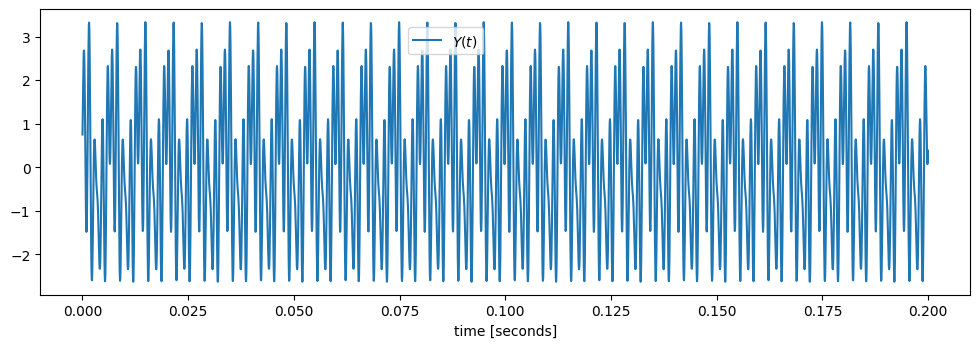

In [11]:
width  = 12.0
height = width / 1.618 / 2.

fig, ax  = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, figsize=(width, height))
ax.plot(data[:,0], data[:,2], linestyle='-', label=r'$Y(t)$')
fig.legend(ncol=1, bbox_to_anchor=(0.5, 0.85))
ax.set_xlabel('time [seconds]')

There are 1600 frequency bins.
The first frequency is 5.0.
The frequency spacing is 5.0.


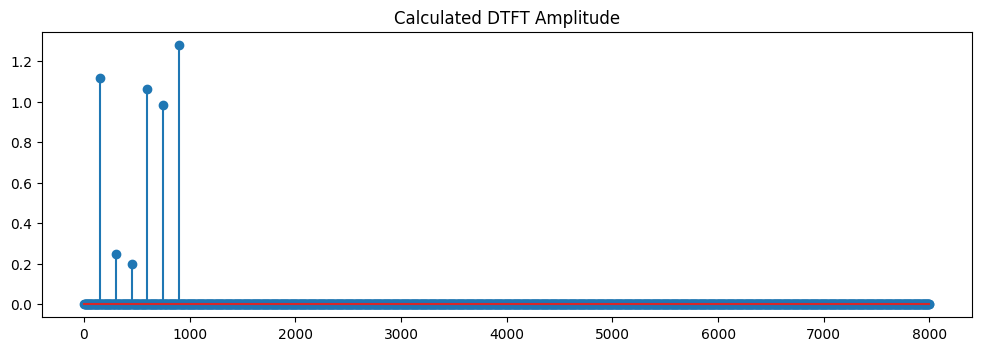

In [12]:
fig, ax  = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=True, figsize=(width, height))
fft = np.fft.rfft(data[:,2])
freq = np.fft.rfftfreq(data_count, d=time_delta)
ax.set_title("Calculated DTFT Amplitude")
ax.stem(freq, 2.0/data_count * np.abs(fft))
print(f"There are {len(freq)-1} frequency bins.")
print(f"The first frequency is {freq[1]}.")
print(f"The frequency spacing is {freq[2] - freq[1]}.")

In [13]:
# The C library is compiled for a specific number of modes. For this example
# file the library should be compiled for 6 modes
MODE_COUNT = MAIN_CONFIG['MODE_COUNT']
mode_numbers = [m for m in range(1, MODE_COUNT + 1)]
assert MODE_COUNT == 250, "Recompile the C library for MODE_COUNT = 250"

In [14]:

# We assume knowledge of the frequency of the single, but no knowledge of the
# phase or the coefficients.
PHASE      = 0.0
COEFFICIENTS = np.zeros((MODE_COUNT,2))

In [15]:
kf_network = KalmanFilterNetwork(
    mode_numbers,
    1.0,
    COEFFICIENTS,
    [
        [0.00005, 0.0],
        [0.0, 0.00005],
    ],
    2.0
)

In [16]:
estimate     = np.zeros((len(data), 1))
error        = np.zeros((len(data), 1))
predictions  = np.zeros((len(data), MODE_COUNT))
phase        = np.zeros((len(data), 1))
frequency    = np.zeros((len(data), 1))
gain         = np.zeros((len(data), MODE_COUNT, 2))
coefficients = np.zeros((len(data), MODE_COUNT, 2))
power        = np.zeros((MODE_COUNT, len(data)))
convergence  = np.zeros((MODE_COUNT, len(data)))

In [17]:
for ndx, row in enumerate(data):
    observation = row[2]

    # Evolve the state and handle initial conditions
    if ndx == 0:
        frequency[ndx] = FREQUENCY
        phase[ndx]     = PHASE
    elif ndx > 0:
        frequency[ndx]  = frequency[ndx-1]
        phase[ndx]      = phase[ndx-1]
        phase[ndx]     += dimensionless_mode_parameter

    phase[ndx] = np.mod(phase[ndx], 2*np.pi)

    ## Update the prior
    kf_network.prior_update(phase[ndx], observation)

    ## Update the posterior
    kf_network.posterior_update()

    ## Log values
    estimate[ndx,0] = kf_network.prediction
    error[ndx,0]    = kf_network.error

    for mode_ndx in range(MODE_COUNT):
        convergence[mode_ndx, ndx] = kf_network.kf_modes[mode_ndx].convergence
        predictions[ndx, mode_ndx] = kf_network.kf_modes[mode_ndx].prediction

        # coefficients[ndx, mode_ndx, 0] = kf_network.kf_modes[mode_ndx].coefficients[0]
        # coefficients[ndx, mode_ndx, 1] = kf_network.kf_modes[mode_ndx].coefficients[1]
        # gain[ndx, mode_ndx, 0] = kf_network.kf_modes[mode_ndx].gain[0]
        # gain[ndx, mode_ndx, 1] = kf_network.kf_modes[mode_ndx].gain[1]
        power[mode_ndx, ndx] = kf_network.kf_modes[mode_ndx].power

In [18]:
width  = 12.0
height = width / 1.618 / 2.

Text(0.5, 0, 'time [seconds]')

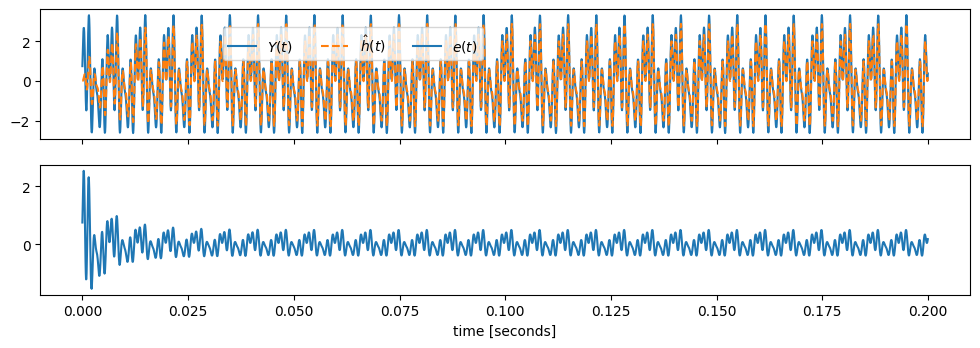

In [19]:
fig, ax  = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(width, height))
ax[0].plot(data[:,0], data[:,2], linestyle='-', label=r'$Y(t)$')
ax[0].plot(data[:,0], estimate[:,0], linestyle='--', label=r'$\hat{h}(t)$')
ax[1].plot(data[:,0], error[:,0], linestyle='-', label=r'$e(t)$')
fig.legend(ncol=3, bbox_to_anchor=(0.5, 0.85))
ax[1].set_xlabel('time [seconds]')

(0.0, 1200.0)

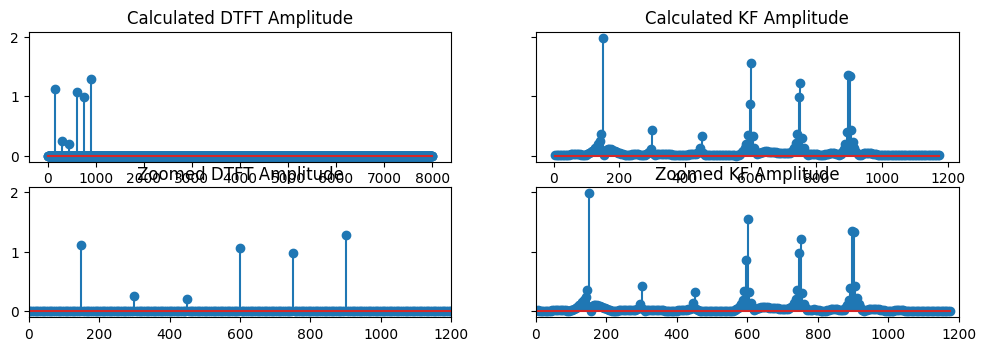

In [20]:
fig, ax  = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=True, figsize=(width, height))
fft = np.fft.rfft(data[:,2])
freq = np.fft.rfftfreq(data_count, d=time_delta)
ax[0, 0].set_title("Calculated DTFT Amplitude")
ax[0, 0].stem(freq, 2.0/data_count * np.abs(fft))
ax[0, 1].set_title("Calculated KF Amplitude")
ax[0, 1].stem(frequency[-1] * np.array(mode_numbers), power[:,-1])

ax[1, 0].set_title("Zoomed DTFT Amplitude")
ax[1, 0].stem(freq, 2.0/data_count * np.abs(fft))
ax[1, 0].set_xlim([0, 1200])
ax[1, 1].set_title("Zoomed KF Amplitude")
ax[1, 1].stem(frequency[-1] * np.array(mode_numbers), power[:,-1])
ax[1, 1].set_xlim([0, 1200])

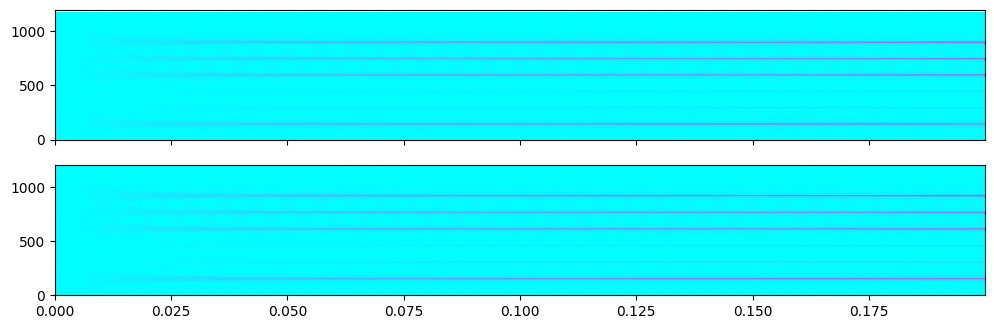

In [21]:

fig, ax  = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(width, height))
ax[0].imshow(power, aspect='auto', cmap='cool', extent=[0, data[-1,0], 0, FREQUENCY*MODE_COUNT], origin='lower')
ax[1].imshow(power, aspect='auto', cmap='cool', extent=[0, data[-1,0], 0, 1200], origin='lower')


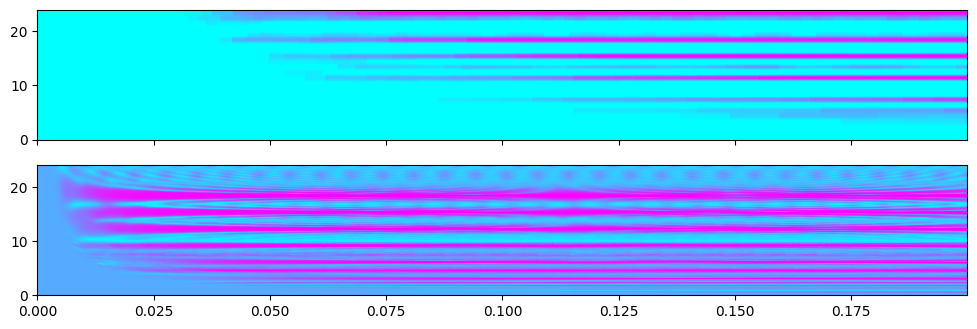

In [22]:
fig, ax  = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(width, height))
ax[0].imshow(convergence, aspect='auto', cmap='cool', vmin=0.0, vmax=1.0, extent=[0, data[-1,0], 0, MODE_COUNT], origin='lower')
ax[1].imshow(convergence, aspect='auto', cmap='cool', extent=[0, data[-1,0], 0, 24], origin='lower')

Text(0.5, 0, 'time [seconds]')

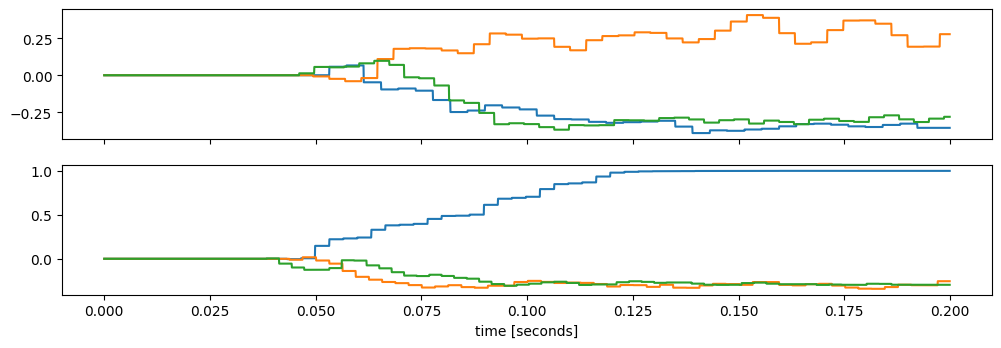

In [23]:
fig, ax  = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(width, height))
ax[0].plot(data[:,0], convergence[12], linestyle='-', label=r'$r^3(t)$')
ax[0].plot(data[:,0], convergence[13], linestyle='-', label=r'$r^3(t)$')
ax[0].plot(data[:,0], convergence[14], linestyle='-', label=r'$r^3(t)$')
ax[1].plot(data[:,0], convergence[15], linestyle='-', label=r'$r^3(t)$')
ax[1].plot(data[:,0], convergence[16], linestyle='-', label=r'$r^3(t)$')
ax[1].plot(data[:,0], convergence[17], linestyle='-', label=r'$r^3(t)$')
ax[1].set_xlabel('time [seconds]')

<StemContainer object of 3 artists>

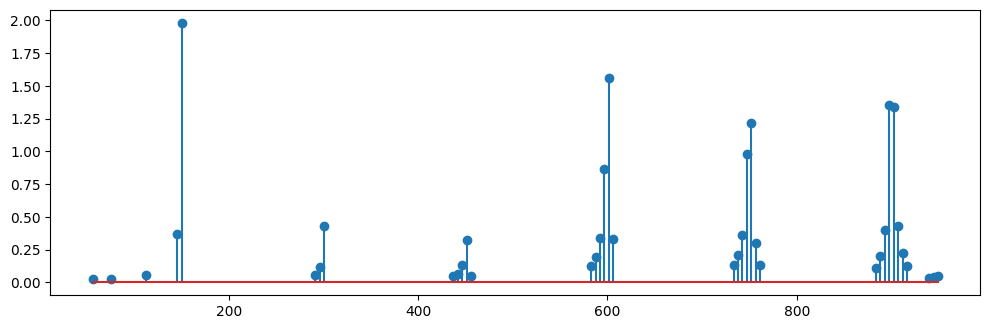

In [24]:
fig, ax  = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=True, figsize=(width, height))
model_index = (power[:,-1] > 0.02) & (convergence[:,-1] > 0.7)
ax.stem(FREQUENCY * np.array(mode_numbers)[model_index], power[model_index,-1])